In [ ]:
import scipy.sparse as sps
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.constants import k

def BdG_Hamiltonian_Spin(n,  delta_in_list, T,  t =1, V =1, periodic = True):
  '''
  Função que preenche uma SciPy Sparse Matrix baseada
  no número de sítios e nas regras de formação para as
  diagonais do sistema em questão

  Argumentos:
  n: número de sítios(int)
  delta_in: gap superconductor(float)
  T: Temperatura do sistema(float)
  t: Termo de hopping(float)
  V: Parâmetro superconductor
  periodic: Periodic Boundary Conditions(Boolean)

  Return: Retorna a matriz sparsa construída
  '''

  #Preenche somente uma vez os termos de hopping triangularmente
  aux = 1
  if(aux == 1):
    rows, cols = 2*n, 2*n
    hopping = sps.dok_matrix((rows, cols))
    values = t*np.ones((n-1))
    values = np.append(values, 0)
    values = np.append(values, -values)
    hopping.setdiag(values, k=1)
    if (periodic == True):
      hopping[0,n-1] = t
      hopping[n,2*n-1] = -t

    aux = 0


  #Preenche os deltas triangularmente
  delta = sps.dok_matrix((rows, cols))
  b = delta_in_list
  delta.setdiag(b, k = n)
  if (periodic == True):
    delta[0,2*n-1] = delta_in
    delta[n,n-1] = -delta_in


  #Soma as duas matrizes
  f = delta + hopping

  #Prenche o triangulo inferior
  f = f.T + f

  return f

[[ 0.  1.  0.  1.  0.  0.]
 [ 1.  0.  1.  0.  2.  0.]
 [ 0.  1.  0.  0.  0.  3.]
 [ 1.  0.  0.  0. -1.  0.]
 [ 0.  2.  0. -1.  0. -1.]
 [ 0.  0.  3.  0. -1.  0.]]
[-3.21018413 -2.47089552 -1.26071139  1.26071139  2.47089552  3.21018413]


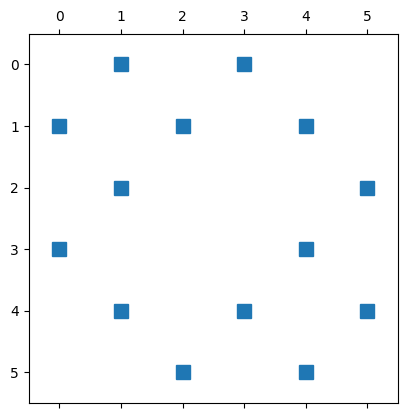

In [ ]:
#Teste visualização

import matplotlib.pylab as plt
import scipy.sparse as sparse

import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

#BdG_Hamiltonian(n,  delta_in, T,  t =1, V =1, periodic = True)
delta_list = [i+1 for  i in range(3)]

A=BdG_Hamiltonian_Spin(n = 3, delta_in_list = delta_list, T = 0.5, t= 1, V = 0.1,periodic = False)
plt.spy(A)

print(A.toarray())
from scipy.linalg import eigh
eigenvals, eigenvecs = eigh(A.toarray())
print(eigenvals)

In [ ]:
def gap_function(n, T_array, t=1, V=1, epsilon=1e-2, delta_guess = 1.0):
  '''
  Função que calcula o gap de um sistema de modo
  autoconsistente para uma lista de temperaturas

  Argumentos:
  n: número de sítios(int)
  T_array: lista de temperaturas do sistema(list of floats)
  t: Termo de hopping(float)
  V: Parâmetro superconductor(float)
  epsilon: Valor de convergência para a autoconsistência(float)

  Return: lista de valores de delta em função da temperatura
  '''
  delta_array = []
  delta_in = 1.0




  for i, T in enumerate(T_array):
    print(f"Computing delta for T = {T}...", delta_in)
    if i == 0:
      # Initial guess for the first temperature
      delta_in = delta_guess
    else:
      # Use the last computed delta as the initial guess for the next temperature
      delta_in = delta_array[i-1]

    # Compute the gap using self-consistent calculation
    c= 0
    delta_list = [1 for  i in range(2*n)]
    delta_in = [1 for  i in range(2*n)]
    while True:
      sparse = BdG_Hamiltonian_Spin(n, t=t, delta_in_list=delta_list, V=V, T=T, periodic = False)
      eigenvalues, eigenvectors = eigh(sparse.toarray())
      #print(sparse.toarray())
      for j in range(2*n):
        delta_next = 0.0
        for i in range(n):
          u, v = np.split(eigenvectors[:, j], 2)
          delta_next += V * v[i] * u[i] * np.tanh(eigenvalues[j] / (2*k*T))
        print(delta_next, delta_in[j])


        delta_list[j] = delta_next
        '''print(delta_list)
        print("in")
        print(delta_in)'''



      epsilon =2*max(eigenvalues)*np.exp(-1/(1045*V))/1000000

      conditions = []

      # Add conditions dynamically
      for i in range(n):
        print(i)
        conditions.append(abs(delta_list[i] - delta_in[i]) < epsilon)

        '''print((abs(delta_list[i] - delta_in[i])))
        print("delta")
        print(delta_list[i],  delta_in[i])'''

      # Check if all conditions are true
      if all(conditions):
        print("condition")
        for i in range(2*n):
          delta_in[i] = delta_list[i]
        break
      else:
        for i in range(2*n):
          delta_in[i] = delta_list[i]

    delta_array.append(delta_in)

  print(epsilon)
  print(eigenvalues)
  return delta_array


In [ ]:
from scipy.constants import k
import matplotlib.pyplot as plt

#k = 0.0861733
k=1.0
T_array = np.linspace(1e-2, 200, 50)
t= 1.0
V = 10000*t
n = 20
delta_array = calculate_gaps(n=n, T_array=T_array, V = V, t = t, epsilon=1e-2)


'''plt.scatter(T_array, abs(delta_array[0][:]/delta_array[0][0]),
            label =r"${} sítios; V = {}; t = {}; \Delta(0) = {:.2f}$" .format(n, V, t, delta_array[0][0]))

plt.scatter(T_array, abs(delta_array[1][:]/delta_array[0][1]),
            label =r"${} sítios; V = {}; t = {}; \Delta(0) = {:.2f}$" .format(n, V, t, delta_array[0][1]))
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\frac{\Delta}{\Delta(0)}$')
plt.legend()
plt.show()'''


Calculating the gap for T = 0.01...
Calculating the gap for T = 4.091428571428572...
Calculating the gap for T = 8.172857142857143...
Calculating the gap for T = 12.254285714285716...
Calculating the gap for T = 16.33571428571429...
Calculating the gap for T = 20.41714285714286...
Calculating the gap for T = 24.498571428571434...
Calculating the gap for T = 28.580000000000005...
Calculating the gap for T = 32.66142857142857...
Calculating the gap for T = 36.74285714285715...
Calculating the gap for T = 40.824285714285715...
Calculating the gap for T = 44.90571428571429...
Calculating the gap for T = 48.987142857142864...
Calculating the gap for T = 53.06857142857143...
Calculating the gap for T = 57.150000000000006...
Calculating the gap for T = 61.23142857142857...
Calculating the gap for T = 65.31285714285715...
Calculating the gap for T = 69.39428571428573...
Calculating the gap for T = 73.4757142857143...
Calculating the gap for T = 77.55714285714286...
Calculating the gap for T = 

'plt.scatter(T_array, abs(delta_array[0][:]/delta_array[0][0]),\n            label =r"${} sítios; V = {}; t = {}; \\Delta(0) = {:.2f}$" .format(n, V, t, delta_array[0][0]))\n\nplt.scatter(T_array, abs(delta_array[1][:]/delta_array[0][1]),\n            label =r"${} sítios; V = {}; t = {}; \\Delta(0) = {:.2f}$" .format(n, V, t, delta_array[0][1]))\nplt.xlabel(\'Temperature (K)\')\nplt.ylabel(r\'$\x0crac{\\Delta}{\\Delta(0)}$\')\nplt.legend()\nplt.show()'

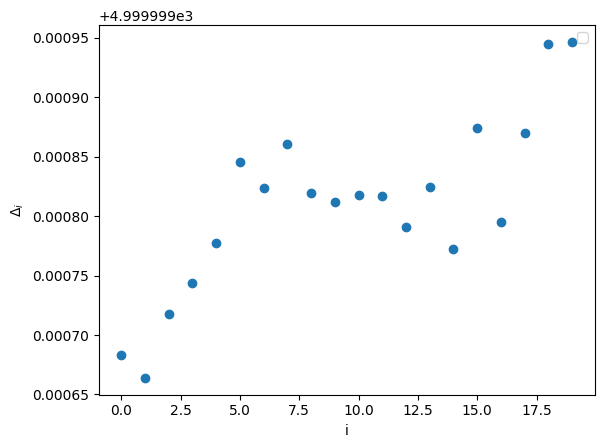

In [ ]:
plt.scatter(range(len(delta_array[0])), delta_array[0])
plt.xlabel('i')
plt.ylabel(r'$\Delta_{i}$')
plt.legend()
plt.show()

In [ ]:
delta_array

[array([4999.99968355, 4999.9996639 , 4999.99971776, 4999.99974356,
        4999.99977769, 4999.99984507, 4999.999824  , 4999.99986103,
        4999.99981919, 4999.9998118 , 4999.99981794, 4999.99981651,
        4999.99979089, 4999.99982464, 4999.99977236, 4999.99987383,
        4999.99979541, 4999.99986951, 4999.9999449 , 4999.99994646]),
 array([4999.99968355, 4999.9996639 , 4999.99971776, 4999.99974356,
        4999.99977769, 4999.99984507, 4999.999824  , 4999.99986103,
        4999.99981919, 4999.9998118 , 4999.99981794, 4999.99981651,
        4999.99979089, 4999.99982464, 4999.99977236, 4999.99987383,
        4999.99979541, 4999.99986951, 4999.9999449 , 4999.99994646]),
 array([4999.99968355, 4999.9996639 , 4999.99971776, 4999.99974356,
        4999.99977769, 4999.99984507, 4999.999824  , 4999.99986103,
        4999.99981919, 4999.9998118 , 4999.99981794, 4999.99981651,
        4999.99979089, 4999.99982464, 4999.99977236, 4999.99987383,
        4999.99979541, 4999.99986951, 4999.9

In [ ]:
#data generating
from scipy.constants import k
import matplotlib.pyplot as plt


k = 0.0861733
T_array = np.linspace(0.01, 310, 100)
V_array = np.linspace(25, 100, 50)
N_array = [10,25,50,100]
#data = np.stack((delta_array, T_array, n*np.ones(len(T_array)), V*np.ones(len(T_array))), axis = 1)
for n in N_array:
  for V in V_array:
    delta_array = gap_function(n=int(n), T_array=T_array, V = V)
    new_data = np.stack((delta_array, T_array, n*np.ones(len(T_array)), V*np.ones( len(T_array))), axis = 1)
    data = np.vstack((new_data, data))



A saída de streaming foi truncada nas últimas 5000 linhas.
Computing delta for T = 144.04575757575756... 44.04765596234439
Computing delta for T = 147.1769696969697... 43.81411510704648
Computing delta for T = 150.30818181818182... 43.564041739506486
Computing delta for T = 153.43939393939394... 43.30155058096068
Computing delta for T = 156.57060606060605... 43.027284622442224
Computing delta for T = 159.70181818181817... 42.73628813225954
Computing delta for T = 162.8330303030303... 42.42708082908671
Computing delta for T = 165.96424242424243... 42.10630197481584
Computing delta for T = 169.09545454545454... 41.76820720491548
Computing delta for T = 172.22666666666666... 41.41088541262277
Computing delta for T = 175.35787878787878... 41.0407256579956
Computing delta for T = 178.48909090909092... 40.64980884788714
Computing delta for T = 181.62030303030303... 40.242447090085065
Computing delta for T = 184.75151515151515... 39.81986438998571
Computing delta for T = 187.88272727272727...

In [ ]:
len(data)

40100

In [ ]:
-np.log(92.04/(2*130.87))*1000

1045.1283794601693

(array([3765., 1166., 4526., 6226., 7055., 6921., 7632., 7331., 7873.,
        7605.]),
 array([-0.2712995 ,  9.75483125, 19.78096199, 29.80709274, 39.83322349,
        49.85935423, 59.88548498, 69.91161573, 79.93774647, 89.96387722,
        99.99000796]),
 <BarContainer object of 10 artists>)

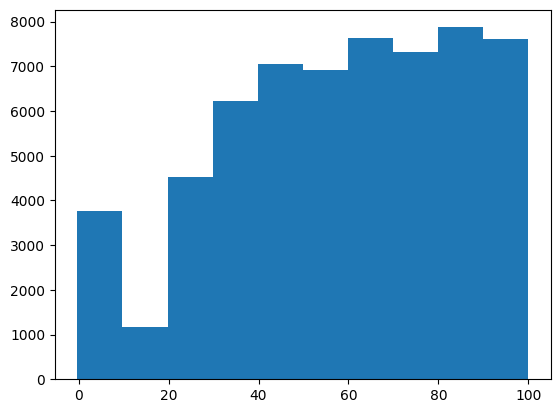

In [ ]:
plt.hist(Y)

N(0) = 1045.13

$$\Delta = 2ħ ω_C exp(\frac{-1}{N(0)V})$$

Computing delta for T = 0.01... 1.0
Computing delta for T = 100.0... 99.98999721562431
0.02000574467245359
[-2.00059361 -2.00011249 -2.00010885 ...  2.00010885  2.00011249
  2.00059361]
[99.98999721562431, 0.010991067048901093]


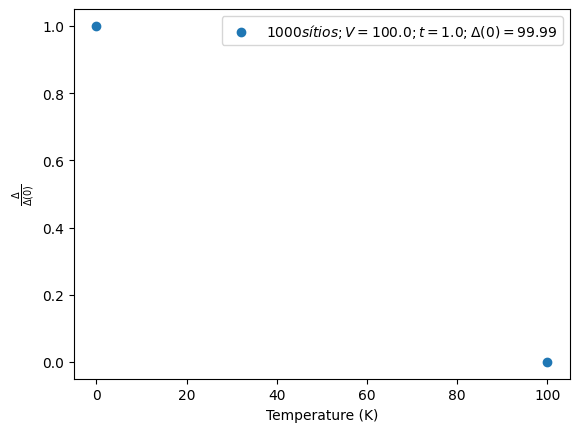

In [ ]:
from scipy.constants import k
import matplotlib.pyplot as plt

#k = 0.0861733
k=1.0
T_array = np.linspace(1e-2, 100, 2)
t=1.0
V = 100*t
n = 1000
delta_array = gap_function(n=n, T_array=T_array, V = V, t = t, epsilon=1e-2)

print(delta_array)


plt.scatter(T_array, abs(delta_array/delta_array[0]),
            label =r"${} sítios; V = {}; t = {}; \Delta(0) = {:.2f}$" .format(n, V, t, delta_array[0]))
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\frac{\Delta}{\Delta(0)}$')
plt.legend()
plt.show()